# Global mean Sea Surface Temperatures

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib.dates import DateFormatter
import platform
import os

from dask.distributed import Client
from dask import delayed
import dask

import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature

plt.rcParams['figure.figsize'] = (10, 4)

#### Settings

In [53]:
year1= 1982
year2= 2024

In [54]:
#To compute de climatoloy
yearC1='1982'
yearC2='1992'

In [55]:
HOME=os.environ['HOME']
USER=os.environ['USER']    

## Load data

In [56]:
if os.uname().nodename.lower().find('eemmmbp') != -1:
    base_file = HOME + '/Dropbox/Oceanografia/Data/Satelite/noaa.oisst.v2.highres/NC/sst.day.mean'
    dataDir   = './data'
elif os.uname().nodename.lower().find('rossby') != -1:
    base_file = '/data/shareddata/Satelite/noaa.oisst.v2.highres/NC/sst.day.mean'
    dataDir   = HOME + '/Analisis/SSTGlobalAnalysis/data'

In [57]:
files = [f'{base_file}.{year}.nc' for year in range(year1, year2+1)]
DS = xr.open_mfdataset(files,  chunks={'time': 365})

In [160]:
Titulos = ['Demarcación marina levantino-balear', 'Demarcación marina noratlántica','Demarcación marina canaria','Demarcación sudatlántica','Demarcación Estrecho y Alborán']
Titulos_short = ['LEB', 'NOR','CAN','SUD','ESA']

In [161]:
# Load data1

#titulo_short = 'NH'
#titulo = 'Northern hemisphere'
#sst = DS.sst.sel(lat=slice(0,80))

#titulo_short = 'SH'
#titulo = 'Southern hemisphere'
#sst = DS.sst.sel(lat=slice( -80, 0))

#titulo_short = 'GO'
#titulo = 'Global Ocean'
#sst = DS.sst.sel(lat=slice( -80, 80))

#titulo_short = 'AtlNino'
#titulo = 'Atlantico El Niño'
#sst = DS.sst.sel(lon=slice(360-25.,360),lat=slice( -10,0))

In [205]:
i=4

In [206]:
titulo = Titulos[i]
titulo_short = Titulos_short[i]
if  titulo_short == 'LEB':
        sst = DS.sst.sel(lat=slice(36,43)).sel(lon=slice(0,6.5))
        print('>>>>> '+titulo)        
elif  titulo_short == 'NOR':
        sst = DS.sst.sel(lat=slice(41.25,47)).sel(lon=slice(345.5,358.50))
        print('>>>>> '+titulo)        
elif  titulo_short == 'CAN':
        sst = DS.sst.sel(lat=slice(24.3,32.5)).sel(lon=slice(337.75,349.75))
        print('>>>>> '+titulo)
elif  titulo_short == 'SUD':
        sst = DS.sst.sel(lat=slice(35.5,37.40)).sel(lon=slice(352,354.25))
        print('>>>>> '+titulo)
elif  titulo_short == 'ESA':
        sst = DS.sst.sel(lat=slice(35.6,37)).sel(lon=slice(354,358.25))
        print('>>>>> '+titulo)

>>>>> Demarcación Estrecho y Alborán


In [207]:
escalaLand='50m'
if titulo_short == 'NH':
        escalaLand='110m'
elif titulo_short == 'SH':
        escalaLand='110m'
elif titulo_short == 'GO':
        escalaLand='110m'

In [208]:
# Load the data from the .txt file
lon, lat = [], []
if titulo_short == 'CAN' or titulo_short == 'ESA' or titulo_short ==  'LEB' or titulo_short ==  'NOR' or titulo_short ==  'SUD' :
    with open('./LimiteDemarcaciones/Demarcacion'+titulo_short+'.txt', 'r') as f:
        for line in f:
            # Split the line by whitespace and append the values
            longitude, latitude = map(float, line.split())
            lon.append(longitude)
            lat.append(latitude)

## Global mean

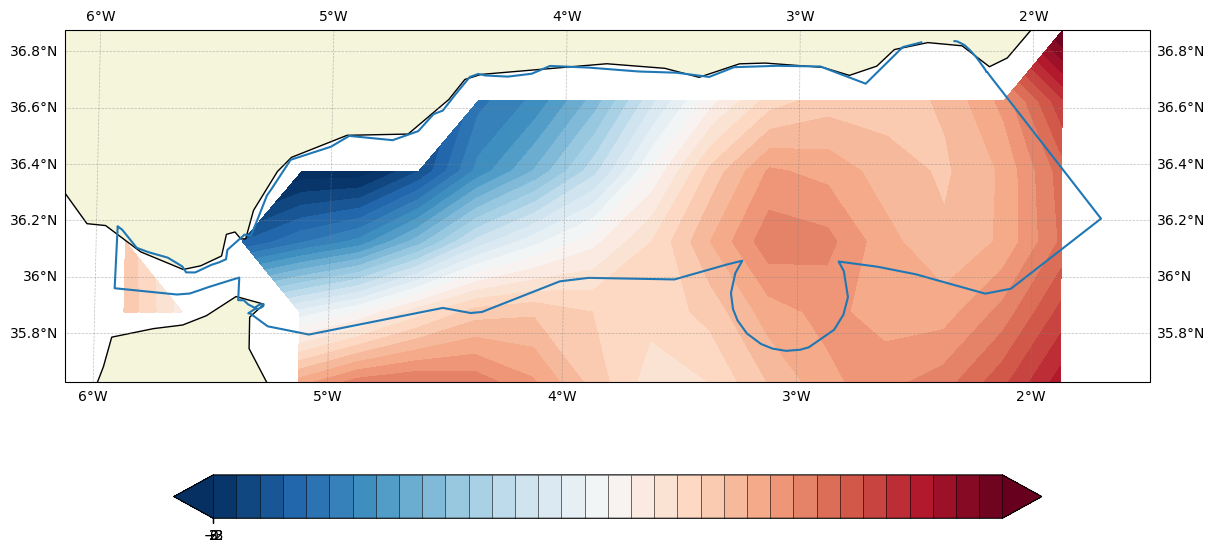

In [209]:
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

land = cartopy.feature.NaturalEarthFeature('physical',  'land', edgecolor='k', scale = escalaLand ,
                facecolor=cfeature.COLORS['land'])

ax.add_feature(land, facecolor='beige')
    
cm=ax.contourf(sst.lon,sst.lat,sst[-1,:,:],  40,
               transform=ccrs.PlateCarree(),
               cmap = plt.cm.RdBu.reversed(),extend='both')

ax.plot(lon, lat, transform=ccrs.PlateCarree())

cbar=fig.colorbar(cm,ax=ax, location='bottom',
                  shrink=.8, ticks=[-3,-2,0,2,3], 
                  drawedges=True)

ax.gridlines(draw_labels=True, linewidth=.5, 
             color='gray', alpha=0.5, linestyle='--')

In [204]:
# Calculate global mean weigthtened
# For a rectangular grid the cosine of the latitude is proportional to the grid cell area.
weights = np.cos(np.deg2rad(sst.lat))
weights = weights/weights.max()
weights.name = "weights"
sst_weighted = sst.weighted(weights)
sst_wmean = sst_weighted.mean(("lon", "lat"),skipna=True).load()

## Seasonal cycle
Create seasonal climatology from 1982 to 1992 and the asociated anomaly

In [44]:
#Create monthly climatology
sst_clim = sst.sel(time=slice(yearC1,yearC2)).groupby('time.dayofyear').mean(dim='time').load();

In [36]:
#Create anomaly
sst_anom = sst.groupby('time.dayofyear') - sst_clim

/Users/pvb/miniconda3/envs/ocean/lib/python3.11/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing with an out-of-order index is generating 43 times more chunks
  return self.array[key]


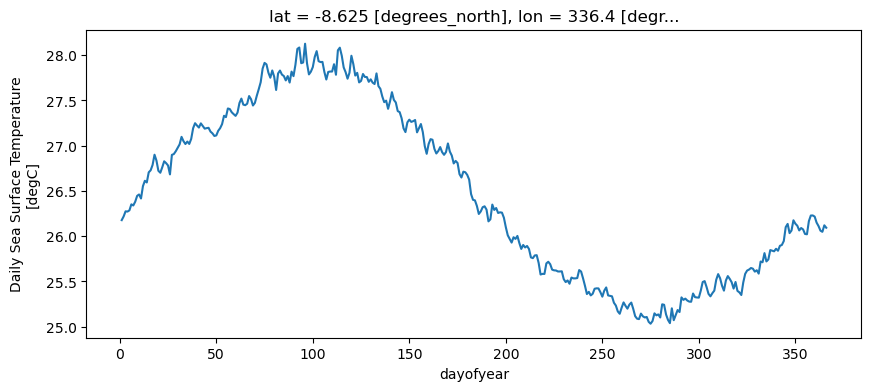

In [37]:
sst_clim[:,5,5].plot()

## Global mean anomaly

In [38]:
# Calculate global mean weigthtened
# For a rectangular grid the cosine of the latitude is proportional to the grid cell area.
weights = np.cos(np.deg2rad(sst.lat))
weights = weights/weights.max()
weights.name = "weights"
sst_anom_weighted = sst_anom.weighted(weights)
sst_anom_wmean = sst_anom_weighted.mean(("lon", "lat"),skipna=True).load()

In [39]:
# smoothed versions
sst_wmean_rolling = sst_wmean.rolling(time=360,center=True).mean()
sst_anom_wmean_rolling = sst_anom_wmean.rolling(time=360,center=True).mean()

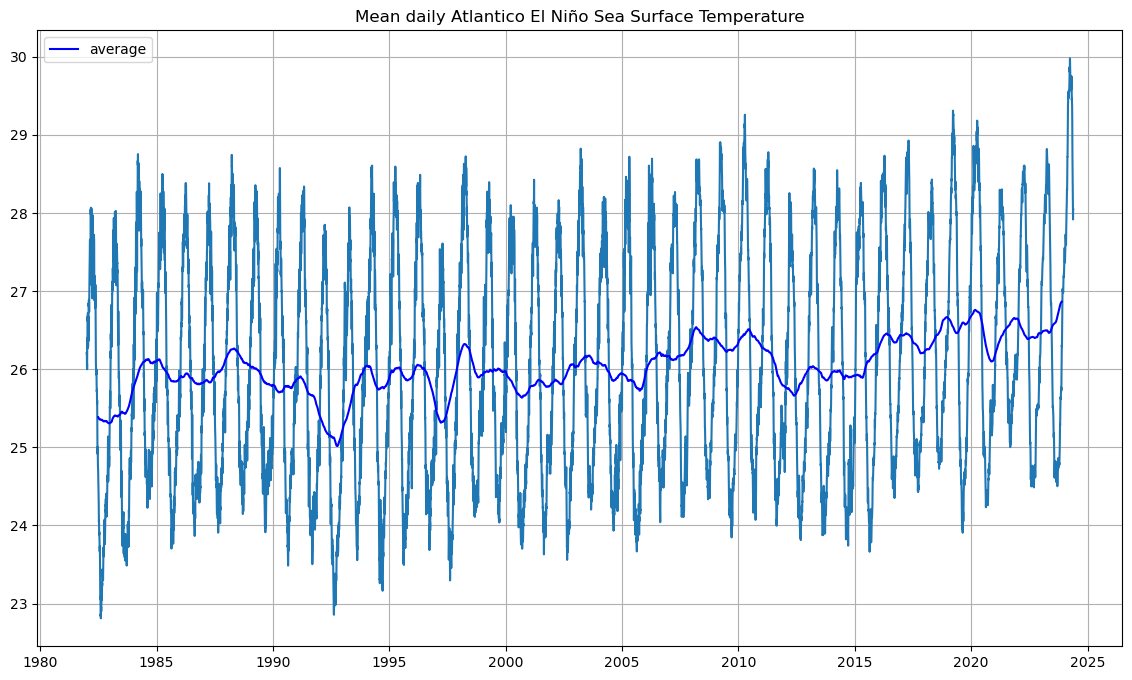

In [40]:
fig, ax = plt.subplots(1, 1 , figsize=(14,8))
ax.plot(sst_wmean.time,sst_wmean)
ax.plot(sst_wmean_rolling.time,sst_wmean_rolling,'-b',label='average')
ax.grid()
ax.legend()
ax.set_title('Mean daily '+titulo+' Sea Surface Temperature');

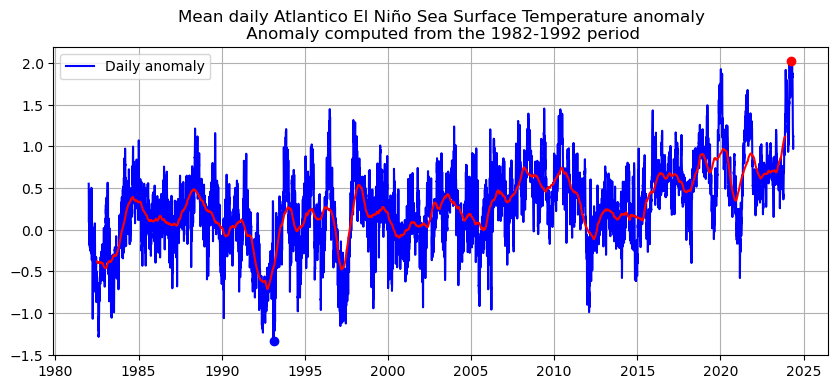

In [41]:
fig, ax = plt.subplots(1, 1 , figsize=(10,4))
ax.plot(sst_anom_wmean.time        ,sst_anom_wmean,'b',label='Daily anomaly')
ax.plot(sst_anom_wmean_rolling.time,sst_anom_wmean_rolling,'r')

ax.plot(sst_anom_wmean.time.isel(sst_anom_wmean.argmax(...)),
        sst_anom_wmean.isel(sst_anom_wmean.argmax(...)),'ro')
ax.plot(sst_anom_wmean.time.isel(sst_anom_wmean.argmin(...)),
        sst_anom_wmean.isel(sst_anom_wmean.argmin(...)),'bo')

ax.grid()
ax.legend()
ax.set_title('Mean daily '+titulo+' Sea Surface Temperature anomaly\n Anomaly computed from the 1982-1992 period');

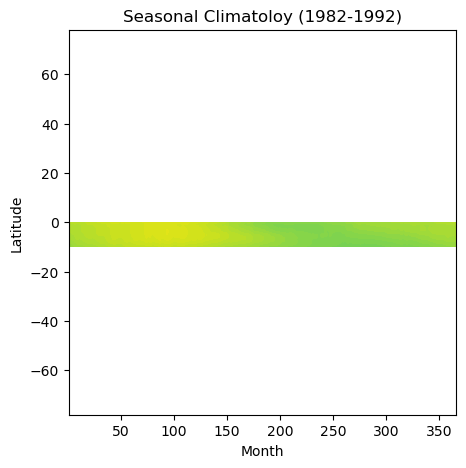

In [42]:
fig, ax = plt.subplots(1, 1 , figsize=(5,5))
ax.contourf(sst_clim.mean(dim='lon').dayofyear,
                 sst_clim.mean(dim='lon').lat,
                 sst_clim.mean(dim='lon').transpose(),levels=12, vmin=-2, vmax=30)
ax.set_ylim(-78,78)
ax.grid()
ax.set_title('Seasonal Climatoloy (' + yearC1 + '-' + yearC2 + ')')
ax.set_ylabel('Latitude') 
ax.set_xlabel('Month')
ax.grid()

In [43]:
sst_anom_LD=sst_anom[-1,:,:]
sst_anom_LD

<xarray.DataArray 'sst' (lat: 40, lon: 100)> Size: 16kB
dask.array<getitem, shape=(40, 100), dtype=float32, chunksize=(40, 100), chunktype=numpy.ndarray>
Coordinates:
    time       datetime64[ns] 8B 2024-05-19
  * lat        (lat) float32 160B -9.875 -9.625 -9.375 ... -0.625 -0.375 -0.125
  * lon        (lon) float32 400B 335.1 335.4 335.6 335.9 ... 359.4 359.6 359.9
    dayofyear  int64 8B 140

In [21]:
sst_anom_LD.to_netcdf(dataDir + '/PsstLD_anom_'+titulo_short+'.nc',mode='w')
sst_wmean.to_netcdf(dataDir + '/Psstd_mean_'+titulo_short+'.nc',mode='w')
sst_clim.to_netcdf(dataDir + '/Psstd_clim_'+titulo_short+'.nc',mode='w')
sst_anom_wmean.to_netcdf(dataDir + '/Psstd_anom_mean_'+titulo_short+'.nc',mode='w')